<a href="https://colab.research.google.com/github/grewe/StrokeChangeMLTraining/blob/main/LabeledData-Mouth-Regression/Mouth_4_Classes_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Image Regression from Standard Tensorflow hub model -retrain, eval and test**

### **Difference between this and [Image Regression Colab](https://colab.research.google.com/drive/1zTBkXTBzVsfUs3gZ1mKOVs9Pm4XYu4nv#scrollTo=6w9q_Hvv-sJS)** is that attempt to ensure the ordering of images with corresponding severity is explicity created --but, both should work. 

### In this colab notebook, you'll learn how to
 

*  train a custom image regression model from a pre-existing model 
*  tune parameters
*  evaluate it
*  run test cases and plot results
*  run tensorboard
*  save it to Saved_Model
*  export as TFLite


This colab is expecting the data to be the evaluation of images against a regression value called "severity".

The intended use is for training a Stroke Eye Severity Regression model and the separate Stroke Model Severity Regression Model.





# **Simple Image Regression using Tensorflow**

***need to use linear regressor instead of logistic regressor.***


How is this done:  
*   The only difference from classification the metric for loss ---see below is where mean_absolute_errror is used and in our case the final output layer has a cardinality of 1  (which represents "severity" our target regression value)

 
```
 model.compile(
        optimizer=optimizer, loss="mean_absolute_error", metrics=[MeanAbsoluteError(), MeanAbsolutePercentageError()]
    )
```

*  Once the model is built, configure the training procedure using the Keras Model.compile method. The most important arguments to compile are the loss and the optimizer, since these define what will be optimized (mean_absolute_error) and how (using the tf.keras.optimizers.Adam).



References:
* https://www.tensorflow.org/tutorials/keras/regression
* https://rosenfelder.ai/keras-regression-efficient-net/


# **Expected Data**



*   images_dir = directory containing only the images
*   regressionData.csv = a CSV file containing a column = "image" which is the filename of an image and column = "severity" which is the corresponding severity value (in our case from 0 to 10)

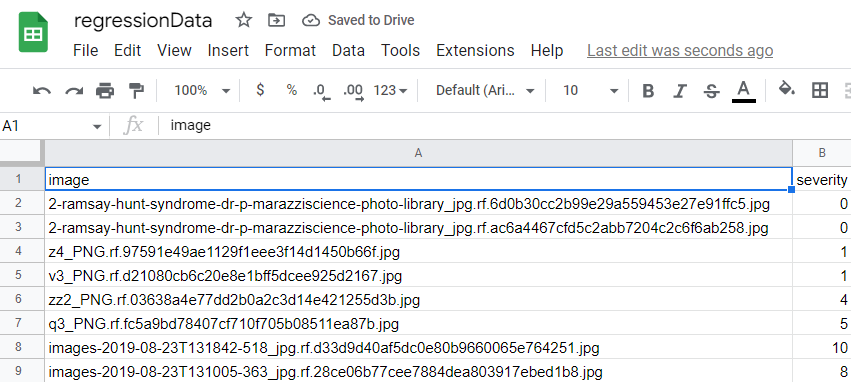



In [ ]:
# Copyright 2021 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# STEP 0: mount Drive and install libraries and import packages

### assumes data in drive/Mask/MaskDetect/data


Here you'll use the dataset given in the zip file (http://borg.csueastbay.edu/~grewe/CS663/Mat/TensorFlow/TensorFlowLiteModelMaker/data.zip).

*  grab the zip and unzip and upload the content to your drive in the path YOUDRIVE/Mask/MaskDetect

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

## STEP 1:  SETUP

In [ ]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

import pandas as pd

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

## Select the TF2 SavedModel module to use & specify BATCH_SIZE, determine IMAGE_SIZE to allign with model input size

For starters, use [https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4](https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4). The same URL can be used in code to identify the SavedModel and in your browser to show its documentation. (Note that models in TF1 Hub format won't work here.)

You can find more TF2 models that generate image feature vectors [here](https://tfhub.dev/s?module-type=image-feature-vector&tf-version=tf2).

There are multiple possible models to try. All you need to do is select a different one on the cell below and follow up with the notebook.

In [ ]:
#@title

model_name = "efficientnetv2-b0" # @param ['efficientnetv2-s', 'efficientnetv2-m', 'efficientnetv2-l', 'efficientnetv2-s-21k', 'efficientnetv2-m-21k', 'efficientnetv2-l-21k', 'efficientnetv2-xl-21k', 'efficientnetv2-b0-21k', 'efficientnetv2-b1-21k', 'efficientnetv2-b2-21k', 'efficientnetv2-b3-21k', 'efficientnetv2-s-21k-ft1k', 'efficientnetv2-m-21k-ft1k', 'efficientnetv2-l-21k-ft1k', 'efficientnetv2-xl-21k-ft1k', 'efficientnetv2-b0-21k-ft1k', 'efficientnetv2-b1-21k-ft1k', 'efficientnetv2-b2-21k-ft1k', 'efficientnetv2-b3-21k-ft1k', 'efficientnetv2-b0', 'efficientnetv2-b1', 'efficientnetv2-b2', 'efficientnetv2-b3', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'bit_s-r50x1', 'inception_v3', 'inception_resnet_v2', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224']

model_handle_map = {
  "efficientnetv2-s": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2",
  "efficientnetv2-m": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_m/feature_vector/2",
  "efficientnetv2-l": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/2",
  "efficientnetv2-s-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/2",
  "efficientnetv2-m-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_m/feature_vector/2",
  "efficientnetv2-l-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_l/feature_vector/2",
  "efficientnetv2-xl-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2",
  "efficientnetv2-b0-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2",
  "efficientnetv2-b1-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b1/feature_vector/2",
  "efficientnetv2-b2-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b2/feature_vector/2",
  "efficientnetv2-b3-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b3/feature_vector/2",
  "efficientnetv2-s-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/feature_vector/2",
  "efficientnetv2-m-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_m/feature_vector/2",
  "efficientnetv2-l-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_l/feature_vector/2",
  "efficientnetv2-xl-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_xl/feature_vector/2",
  "efficientnetv2-b0-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2",
  "efficientnetv2-b1-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b1/feature_vector/2",
  "efficientnetv2-b2-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b2/feature_vector/2",
  "efficientnetv2-b3-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/feature_vector/2",
  "efficientnetv2-b0": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2",
  "efficientnetv2-b1": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/feature_vector/2",
  "efficientnetv2-b2": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b2/feature_vector/2",
  "efficientnetv2-b3": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b3/feature_vector/2",
  "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
  "efficientnet_b1": "https://tfhub.dev/tensorflow/efficientnet/b1/feature-vector/1",
  "efficientnet_b2": "https://tfhub.dev/tensorflow/efficientnet/b2/feature-vector/1",
  "efficientnet_b3": "https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1",
  "efficientnet_b4": "https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1",
  "efficientnet_b5": "https://tfhub.dev/tensorflow/efficientnet/b5/feature-vector/1",
  "efficientnet_b6": "https://tfhub.dev/tensorflow/efficientnet/b6/feature-vector/1",
  "efficientnet_b7": "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1",
  "bit_s-r50x1": "https://tfhub.dev/google/bit/s-r50x1/1",
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature-vector/4",
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature-vector/4",
  "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature-vector/4",
  "resnet_v1_101": "https://tfhub.dev/google/imagenet/resnet_v1_101/feature-vector/4",
  "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature-vector/4",
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature-vector/4",
  "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/feature-vector/4",
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature-vector/4",
  "nasnet_large": "https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/4",
  "nasnet_mobile": "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/4",
  "pnasnet_large": "https://tfhub.dev/google/imagenet/pnasnet_large/feature_vector/4",
  "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
  "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
  "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
  "mobilenet_v3_small_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5",
  "mobilenet_v3_small_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5",
  "mobilenet_v3_large_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5",
  "mobilenet_v3_large_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5",
}

model_image_size_map = {
  "efficientnetv2-s": 384,
  "efficientnetv2-m": 480,
  "efficientnetv2-l": 480,
  "efficientnetv2-b0": 224,
  "efficientnetv2-b1": 240,
  "efficientnetv2-b2": 260,
  "efficientnetv2-b3": 300,
  "efficientnetv2-s-21k": 384,
  "efficientnetv2-m-21k": 480,
  "efficientnetv2-l-21k": 480,
  "efficientnetv2-xl-21k": 512,
  "efficientnetv2-b0-21k": 224,
  "efficientnetv2-b1-21k": 240,
  "efficientnetv2-b2-21k": 260,
  "efficientnetv2-b3-21k": 300,
  "efficientnetv2-s-21k-ft1k": 384,
  "efficientnetv2-m-21k-ft1k": 480,
  "efficientnetv2-l-21k-ft1k": 480,
  "efficientnetv2-xl-21k-ft1k": 512,
  "efficientnetv2-b0-21k-ft1k": 224,
  "efficientnetv2-b1-21k-ft1k": 240,
  "efficientnetv2-b2-21k-ft1k": 260,
  "efficientnetv2-b3-21k-ft1k": 300, 
  "efficientnet_b0": 224,
  "efficientnet_b1": 240,
  "efficientnet_b2": 260,
  "efficientnet_b3": 300,
  "efficientnet_b4": 380,
  "efficientnet_b5": 456,
  "efficientnet_b6": 528,
  "efficientnet_b7": 600,
  "inception_v3": 299,
  "inception_resnet_v2": 299,
  "nasnet_large": 331,
  "pnasnet_large": 331,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 224)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 16 #@param {type:"integer"}
print(f"Batch size {BATCH_SIZE}")

#  STEP 2:  Set up the  dataset



## Step 2.1 : read in the regressionData.csv file that contains in csv format the imagename,severity using [pandas DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from typing import Iterator, List, Union, Tuple, Any

In [ ]:
image_dir="drive/MyDrive/LabeledData-Mouth-Regression/data"
main_dir = "drive/MyDrive/LabeledData-Mouth-Regression"
log_dir = "drive/MyDrive/LabeledData-Mouth-Regression/tensorboard/"
print("image_dir\n")
print(image_dir)
!ls $image_dir
dataFile = main_dir + "/regressionData.csv"
!cat $dataFile


In [ ]:
#open a csv file with pandas
pandasDataFrame = pd.read_csv(dataFile)
print(pandasDataFrame)

In [ ]:
print(pandasDataFrame['image'])
print(pandasDataFrame['severity'])

In [ ]:
# add the correct path for the image locations.
pandasDataFrame["image"] = (
        image_dir + "/" + pandasDataFrame["image"]
    )  

In [ ]:
for x in pandasDataFrame["image"]:
  print(x)


## Step 2.2 split the pandas DataFrame (just arrays of image filenames and severities) into train, test, validation.   Uses [train_test_split() from sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)



*  [ pandas DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) api




In [ ]:
from sklearn.model_selection import train_test_split
testAndValid_percent = 0.2  #as decimal percentange of data to form test+valid
test_valid_split_percent = 0.5 #as a decimal the percentage of the test+valid data to test data

def split_data(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Accepts a Pandas DataFrame and splits it into training, testing and validation data. Returns DataFrames.

    Parameters
    ----------
    df : pd.DataFrame
        Your Pandas DataFrame containing all your data.

    Returns
    -------
    Union[pd.DataFrame, pd.DataFrame, pd.DataFrame]
        [description]
    """
    train, val_test = train_test_split(df, test_size=testAndValid_percent, random_state=1)  # split the data with a validation size of train_valid_percent
    val, test = train_test_split( val_test, test_size=test_valid_split_percent, random_state=1)  # split the valid and test data by percent specified above

    print("shape train: ", train.shape)  # type: ignore
    print("shape val: ", val.shape)  # type: ignore
    print("shape test: ", test.shape)  # type: ignore

    print("Descriptive statistics of train:")
    print(train.describe())  # type: ignore
    return train, val, test  # type: ignore


#use function above to split into train test, validation
train, val, test = split_data(pandasDataFrame)

#see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html  for documentation on DataFrames in Pandas

#print out lengths
print("LENGTH:  train test valid:  " + str(len(train)) + ", " + str(len(test)) + ", " + str(len(val)))


#print out data

print("train")
for index, row in train.iterrows():
    print(row["image"], row["severity"])

print("\n\n test")
for index, row in test.iterrows():
    print(row["image"], row["severity"])

print("\n\n valid")
for index, row in val.iterrows():
    print(row["image"], row["severity"])

print("\n\nshape train: ", train.shape)  # type: ignore
print("shape val: ", val.shape)  # type: ignore
print("shape test: ", test.shape)  # type: ignore

print("\n\nDescriptive statistics of test:")
print(test.describe())  # type: ignore


print(train.info)
print(train.iteritems)
print(train.itertuples)


#STEP 2.3 create numpy arrays of images and corresponding arrays of severity using pandas DataFrame


### Step 2.3.1 load and resize images for training, testing and validation & load severties in corresponding order 



*   input = pandas DataFrames train, test, val containing columns "image" and "severity"
*   output = trainImages,testImage, validationImages :  dictionaries of loaded images that are resized to IMAGE_SIZE (e.g. 224,224 )
*   output =  trainSeveriteis, testSeverities, validationSeverities:  dictionaires of corresponding severities for the trainImages, testImages, etc.





In [ ]:
# see https://datascience.stackexchange.com/questions/106600/how-to-perform-regression-on-image-data-using-tensorflow22
import PIL
trainImages = {}
trainSeverities = {}
i=0
newsize = (IMAGE_SIZE, IMAGE_SIZE)

print("TRAIN Images")
for index, row in train.iterrows():
    trainSeverities[i] = row["severity"]
    img = row["image"]
   # ax = plt.subplot(3, 3, i + 1)  # create a 3x3 grid
    trainImages[i]=np.array(PIL.Image.open(img).resize(IMAGE_SIZE))
    plt.imshow(trainImages[i]) 
    plt.xlabel(trainSeverities[i])
    plt.show()
    i = i+1

plt.close()



print("TEST Images")
testImages = {}
testSeverities = {}
i=0
for index, row in test.iterrows():
    testSeverities[i] = row["severity"]
    img = row["image"]
    #ax = plt.subplot(3, 3, i + 1)  # create a 3x3 grid
    testImages[i]=np.array(PIL.Image.open(img).resize(IMAGE_SIZE))
    plt.imshow(testImages[i]) 
    plt.xlabel(testSeverities[i])
    plt.show()
    i = i+1

plt.close()



print("VALIDATION Images")
validationImages = {}
validationSeverities = {}
i=0
for index, row in val.iterrows():
    validationSeverities[i] = row["severity"]
    img = row["image"]
    #ax = plt.subplot(3, 3, i + 1)  # create a 3x3 grid
    validationImages[i]=np.array(PIL.Image.open(img).resize(IMAGE_SIZE))
    plt.imshow(validationImages[i]) 
    plt.xlabel(validationSeverities[i])
    plt.show()
    i = i+1

plt.close()


print(trainSeverities)


#OPTION OF ABOVE WITH NO PLOT OF TRAIN AND VALID IMAGES TO GO FASTER ---ONLY PLOT TEST IMAGES
# see https://datascience.stackexchange.com/questions/106600/how-to-perform-regression-on-image-data-using-tensorflow
import PIL
trainImages = {}
trainSeverities = {}
i=0
newsize = (IMAGE_SIZE, IMAGE_SIZE)

print("TRAIN Images")
for index, row in train.iterrows():
    trainSeverities[i] = row["severity"]
    img = row["image"]
   # ax = plt.subplot(3, 3, i + 1)  # create a 3x3 grid
    trainImages[i]=np.array(PIL.Image.open(img).resize(IMAGE_SIZE))
   # plt.imshow(trainImages[i]) 
   # plt.xlabel(trainSeverities[i])
   # plt.show()
    i = i+1

#plt.close()



print("TEST Images")
testImages = {}
testSeverities = {}
i=0
for index, row in test.iterrows():
    testSeverities[i] = row["severity"]
    img = row["image"]
    #ax = plt.subplot(3, 3, i + 1)  # create a 3x3 grid
    testImages[i]=np.array(PIL.Image.open(img).resize(IMAGE_SIZE))
    plt.imshow(testImages[i]) 
    plt.xlabel(testSeverities[i])
    plt.show()
    i = i+1

plt.close()



print("VALIDATION Images")
validationImages = {}
validationSeverities = {}
i=0
for index, row in val.iterrows():
    validationSeverities[i] = row["severity"]
    img = row["image"]
    #ax = plt.subplot(3, 3, i + 1)  # create a 3x3 grid
    validationImages[i]=np.array(PIL.Image.open(img).resize(IMAGE_SIZE))
   # plt.imshow(validationImages[i]) 
   # plt.xlabel(validationSeverities[i])
   # plt.show()
    i = i+1

#plt.close()


print(trainSeverities)


### Step 2.3.2  package images into nparrays for input for training, validation and testing



*  input =  trainImages,testImages & validationImages , dictionaries of images
*  ouptupt = nparrays of float32 called trainImageData, testImageData and validationImageData

#### **NOTE:** 
* EfficientNet expects int as input, as it automatically does the conversion to float and rescale to 0-1.0 see https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB0

* HOWEVER my model below puts an input layer in front of the EfficientNEt model so that takes as input float32 values by default so in this block I convert to float32 only.  


In [ ]:
trainImageData = np.array([each for each in trainImages.values()]).astype(np.float32)
validationImageData = np.array([each for each in validationImages.values()]).astype(np.float32)
testImageData = np.array([each for each in testImages.values()]).astype(np.float32)

In [ ]:
print("number train images " + str(trainImageData.shape[0]))
print(trainImageData)

### Step 2.3.2  package severiteis into nparrays for input for training, validation and testing



*  input =  trainSeverities,testSeverities & validationSeverities , dictionaries of images
*  ouptupt = nparrays of float32 called trainSeverity, testSeverity and validationSeverity

In [ ]:
#now setup the severity to be nparrays of float32 from the *Severties (i.e. trainSeverities) dictionaries created above

trainSeverity = np.fromiter(trainSeverities.values(), dtype=np.float32)
print(trainSeverity)

testSeverity = np.fromiter(testSeverities.values(), dtype=np.float32)
print(testSeverity)


validationSeverity = np.fromiter(validationSeverities.values(), dtype=np.float32)
print(validationSeverity)

# **STEP 3: Defining the model**

**All it takes is to put a SINGLE dense layer (1D for output predictions from regression) on top of the `feature_extractor_layer` with the Hub module.**

For speed, we start out with a non-trainable `feature_extractor_layer`, but you can also enable fine-tuning for greater accuracy.

In [ ]:
do_fine_tuning = True #@param {type:"boolean"}

In [ ]:
# Rebuild top  from https://rosenfelder.ai/keras-regression-efficient-net/
print("Building model with", model_handle)
#model expects float input for images 3 channels (rgb) of IMAGE_SIZE (e.g. 224,224 as defined above)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),  #dtype	Optional datatype of the input. When not provided, the Keras default float type will be used.
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(1, name="pred")    #, kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

#  **STEP 4: Training the model for regression**


from https://rosenfelder.ai/keras-regression-efficient-net/
**use loss mean_absolute_error !!!**



```
model.compile(
        optimizer=optimizer, loss="mean_absolute_error", metrics=[MeanAbsoluteError(), MeanAbsolutePercentageError()]
    )
```



In [ ]:
from tensorflow.keras.losses import MeanAbsoluteError, MeanAbsolutePercentageError

#setup the  loss as MeanAbsoluteError() so will do regression 
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.0005, momentum=0.9), 
   loss = tf.keras.losses.MeanAbsoluteError())
  # there is some issue with being able to  reload the model from a saved_model if MeanAbsolute Error is 
  #  used as a metric or MeanSquaredError  so commenting this out so can save model and reload it.
  #  see below STEP 13 for information about this.   Also our lossis MeanAbsoluteError so this is already tracked.
  # metrics=[ MeanAbsoluteError()])  #, MeanAbsolutePercentageError() do not use as we have 0 value in our data

 #  recall above for  Classification  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),


# see https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint 
#checkpoints_dir = "drive/MyDrive/iLab/Stroke/LabeledData-Eye-Classifier-4Classes/checkpoints/checkpoint-{epoch:02d}-{val_loss:.2f}.hdf5""
#save every 5 epochs
#for more on checkpoints also see this blog https://towardsdatascience.com/checkpointing-deep-learning-models-in-keras-a652570b8de6
checkpoint_dir = "drive/MyDrive/LabeledData-Mouth-Regression/checkpoints/Run1/checkpoint-{epoch:02d}-{val_loss:.2f}.hdf5"
mc = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir, save_best_only=True, verbose=1, save_freq='epoch')   # save_weights_only=True


#callback for tensorboard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [ ]:
train_size = len(trainImages)
print("TRAIN")
print(train_size)
print("corresponding severity size")
print(len(train["severity"]))

print("\n\nVAL")
val_size = len(validationImages)
print(val_size)
print("corresponding severity size")
print(len(val["severity"]))

In [ ]:

#make validation data a tuple (images array, severity array)
#A tuple (x_val, y_val) of Numpy arrays or tensors.
validationData = (validationImageData, validationSeverity)

In [ ]:
# Train using numpy arrays trainImages, train["severity"]  and validationImages, val["severity"]
# see https://datascience.stackexchange.com/questions/106600/how-to-perform-regression-on-image-data-using-tensorflow
# see model.fit

train_size = len(trainImages)
valid_size = len(validationImages)
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
epochs = 1000

#make validation data a tuple (images array, severity array)
#A tuple (x_val, y_val) of Numpy arrays or tensors.i
validationData = (validationImageData, validationSeverity)
hist = model.fit(
    x=trainImageData,   #x=trainImages,    # images
    y=trainSeverity,  #y=train["severity"],  # severity target regression value
    epochs=epochs, steps_per_epoch=steps_per_epoch,
    validation_data=validationData,
    validation_steps=validation_steps,
    callbacks=[mc, tensorboard_callback]).history   #callback for both checkpoints and tensorboard.

In [ ]:
# Evaluate the model
loss = model.evaluate(testImageData,testSeverity ,batch_size = BATCH_SIZE, verbose=2)
print("trained model, loss: {:5.4f}%".format(100 * loss))

### Simple plot of loss (mean absolute error) ---this can also be seen below in tensorboard

In [ ]:
# DO NOT RUN UNTIL FIXED.
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
#plt.ylim([0,2])
plt.plot(hist["loss"], color='orange')
plt.plot(hist["val_loss"], color='blue') 
plt.legend(["train", "val"], loc ="lower right")



# **STEP 5:  test** -Try out the model on an image from the **test** data:

**Load from saved weights**

In [ ]:
# Rebuild top  from https://rosenfelder.ai/keras-regression-efficient-net/
print("Building model with", model_handle)
#model expects float input for images 3 channels (rgb) of IMAGE_SIZE (e.g. 224,224 as defined above)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),  #dtype	Optional datatype of the input. When not provided, the Keras default float type will be used.
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(1, name="pred")    #, kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

In [ ]:
from tensorflow.keras.losses import MeanAbsoluteError, MeanAbsolutePercentageError

#setup the  loss as MeanAbsoluteError() so will do regression 
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.0005, momentum=0.9), 
   loss = tf.keras.losses.MeanAbsoluteError())
  # there is some issue with being able to  reload the model from a saved_model if MeanAbsolute Error is 
  #  used as a metric or MeanSquaredError  so commenting this out so can save model and reload it.
  #  see below STEP 13 for information about this.   Also our lossis MeanAbsoluteError so this is already tracked.
  # metrics=[ MeanAbsoluteError()])  #, MeanAbsolutePercentageError() do not use as we have 0 value in our data

In [ ]:
#path of model checkpoint
checkpoint_path = "drive/MyDrive/LabeledData-Eye-Regression/checkpoints/checkpoint-10-1.22.hdf5"

# Loads the weights
model.load_weights(checkpoint_path)

In [ ]:
# Evaluate the model
model.evaluate(testImageData, testSeverity ,batch_size = 16, verbose=2)
print("trained model, loss: {:5.4f}%".format(100 * loss))

### **Step 5.1 - Single Image** from either testImages or even trainImages or validationImages arrays already loaded

# NEW CODE
image = trainImages[0]
true_severity = trainSeverity[0]
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
print("prediction_scores output")
print(prediction_scores)
predicted_severity = prediction_scores[0]
print("True Severity: " + str(true_severity))
print("Predicted label: " + str(predicted_severity))

###**Step 5.2 Predict using the TestImageData (np.ndarray of all the test images)**created in step 2

In [ ]:
#use the np.ndarray created above called testImageData
# run this through for predictions and get results

# To write to word document install python-docx
!pip install python-docx

from docx import Document
from docx.shared import Inches

doc_path= "drive/MyDrive/LabeledData-Mouth-Regression/ckpt-1000-detections.docx"


document = Document()

p = document.add_paragraph()
r = p.add_run()

predictions = model.predict(testImageData)
#predictions = model.predict(trainImageData)

images_names = test["image"]
severities = test["severity"]
#images_names = train["image"]
#severities = train["severity"]
for image_name, prediction, severity in zip(images_names, predictions, severities):
    plt.imshow(PIL.Image.open(image_name)) 
   # plt.imshow(img)   #lynne added
    plt.xlabel(" prediction =" +str(prediction) + "\ntrue severity =" + str(severity) + "\n" + str(image_name) )

    plt.savefig('temp.png')
    plt.show()  #lynne added
    
    r.add_picture('temp.png',width=Inches(4.0))
    r.add_break()

document.save(doc_path)
    

In [ ]:
#option save the prediction and original severities to data files
prediction_file = "drive/MyDrive/LabeledData-Mouth-Regression/testing/predictions.txt"
truth_file = "drive/MyDrive/LabeledData-Mouth-Regression/testing/truth.txt"
with open(prediction_file, "w") as txt_file:
    for line in predictions:
        print(line)
        txt_file.write(str(line[0]) + "\n")
      
      
#txt_file.write(line + "\n") # works with any number of elements in a line

#for image_name, prediction, severity in zip(images_names, predictions, severities):

with open(truth_file, "w") as txt_file2:
    for line in severities:
        print(line)
        txt_file2.write(str(line) + "\n")
      
      
#txt_file.write(line + "\n") # works with any number of elements in a line

In [ ]:
#option save the prediction and original severities to data files
prediction_file = "drive/MyDrive/LabeledData-Mouth-Regression/testing/testing.txt"


with open(prediction_file, "w") as txt_file3:
  for image_name, prediction, severity in zip(images_names, predictions, severities):
      line = str(prediction[0])  + " , "  + str(severity) +  " , " + str(image_name) 
      print(line)
      txt_file3.write(str(line) + "\n")
      
      
txt_file3.close()

###**Step 5.3 From a specified directory of raw images**


*  will read in all the images
*  then resize each image to IMAGE_SIZE (e.g. 224,224)
*  then run through model object already in memory (trained above step 4)
*  then displays image, prediction and name of image



In [ ]:
#specify directory to open images from and process
#test_directory = "drive/MyDrive/iLab/Stroke/LabeledData-Eye-Classifier-4Classes/train/strokeEyeMid"
test_directory = image_dir

import re

def open_images(inference_folder: str) -> np.ndarray:
    """Loads images from a folder and prepare them for inferencing.

    Parameters
    ----------
    inference_folder : str
        Location of images for inferencing.

    Returns
    -------
    np.ndarray
        List of images as numpy arrays transformed to fit the efficient_net model input specs.
    """
    images = []
    print("attempting to read images in " + inference_folder)
    # Regex to check valid image file extension.
    regex = "([^\\s]+(\\.(?i)(jpe?g|png|gif|bmp))$)"
    # Compile the ReGex
    p = re.compile(regex)

    for img in os.listdir(inference_folder):
        if(not re.search(p, img)):
          continue 
        img_location =os.path.join(test_directory, img)
        print("  file " +img_location)
        with PIL.Image.open(img_location) as img:  # open image with pillow
            img = img.resize(IMAGE_SIZE)  #lynne added to get input into right size
            #plt.imshow(img)   #lynne added
            #plt.show()  #lynne added
            img = np.array(img)
            img = img[:, :, :3]
            img = np.expand_dims(img, axis=0)  # add 0 dimension to fit input shape of efficient_net

        images.append(img)
    images_array = np.vstack(images)  # combine images efficiently to a numpy array
    return images_array


myTestImages = open_images(test_directory)

predictions = model.predict(myTestImages)

images_names = os.listdir(test_directory)
for image_name, prediction, img in zip(images_names, predictions, myTestImages):
    plt.imshow(img)   #lynne added
    plt.xlabel(" prediction =" +str(prediction) + "\n" + str(image_name)  )
    plt.show()  #lynne added
    

## STEP 5.4 plot results --**NOT DONE**




In [ ]:
#plot results using seaborn and matplotlib
import seaborn as sns
from tensorflow.keras.callbacks import History

def plot_results(model_history_eff_net: History, mean_baseline: float):
    """This function uses seaborn with matplotlib to plot the trainig and validation losses of both input models in an
    sns.relplot(). The mean baseline is plotted as a horizontal red dotted line.

    Parameters
    ----------
    model_history_eff_net : History
        keras History object of the model.fit() method.
    mean_baseline : float
        Result of the get_mean_baseline() function.
    """

    # create a dictionary for each model history and loss type
    dict3 = {
        "MAPE": model_history_eff_net.history["mean_absolute_percentage_error"],
        "type": "training",
        "model": "eff_net",
    }
    dict4 = {
        "MAPE": model_history_eff_net.history["val_mean_absolute_percentage_error"],
        "type": "validation",
        "model": "eff_net",
    }

    # convert the dicts to pd.Series and concat them to a pd.DataFrame in the long format
    s3 = pd.DataFrame(dict3)
    s4 = pd.DataFrame(dict4)
    df = pd.concat([s3, s4], axis=0).reset_index()
    grid = sns.relplot(data=df, x=df["index"], y="MAPE", hue="model", col="type", kind="line", legend=False)
    grid.set(ylim=(20, 100))  # set the y-axis limit
    for ax in grid.axes.flat:
        ax.axhline(
            y=mean_baseline, color="lightcoral", linestyle="dashed"
        )  # add a mean baseline horizontal bar to each plot
        ax.set(xlabel="Epoch")
    labels = ["eff_net", "mean_baseline"]  # custom labels for the plot

    plt.legend(labels=labels)
    plt.savefig("training_validation.png")
    plt.show()

In [ ]:
plot_results(eff_net_history, mean_baseline)

# **STEP 6: Save model as Saved Model**


In [ ]:
saved_model_path = "drive/MyDrive/LabeledData-Mouth-Regression/saved_model"
#tf.saved_model.save(model, saved_model_path)
model.save(saved_model_path)  # see https://www.tensorflow.org/tutorials/keras/save_and_load

#note the above will give a warning when run
# see https://stackoverflow.com/questions/65697623/tensorflow-warning-found-untraced-functions-such-as-lstm-cell-6-layer-call-and
# says to safely ignore

# **STEP 7: Save TFlite model** for deployment to mobile devices

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
tflite_model_location = "drive/MyDrive/LabeledData-Mouth-Regression/tfLiteModel/Run1/model-1000.tflite"
with open(tflite_model_location, 'wb') as f:
  f.write(tflite_model)

# OLD STEP 7 NOT DONE: Deployment to TensorFlow Lite

[TensorFlow Lite](https://www.tensorflow.org/lite) lets you deploy TensorFlow models to mobile and IoT devices. The code below shows how to convert the trained model to TFLite and apply post-training tools from the [TensorFlow Model Optimization Toolkit](https://www.tensorflow.org/model_optimization). Finally, it runs it in the TFLite Interpreter to examine the resulting quality

  * Converting without optimization provides the same results as before (up to roundoff error).
  * Converting with optimization without any data quantizes the model weights to 8 bits, but inference still uses floating-point computation for the neural network activations. This reduces model size almost by a factor of 4 and improves CPU latency on mobile devices.
  * On top, computation of the neural network activations can be quantized to 8-bit integers as well if a small reference dataset is provided to calibrate the quantization range. On a mobile device, this accelerates inference further and makes it possible to run on accelerators like Edge TPU.

In [ ]:
#@title Optimization settings
optimize_lite_model = False  #@param {type:"boolean"}
#@markdown Setting a value greater than zero enables quantization of neural network activations. A few dozen is already a useful amount.
num_calibration_examples = 60  #@param {type:"slider", min:0, max:1000, step:1}
representative_dataset = None
if optimize_lite_model and num_calibration_examples:
  # Use a bounded number of training examples without labels for calibration.
  # TFLiteConverter expects a list of input tensors, each with batch size 1.
  representative_dataset = lambda: itertools.islice(
      ([image[None, ...]] for batch, _ in train_ds for image in batch),
      num_calibration_examples)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
if optimize_lite_model:
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  if representative_dataset:  # This is optional, see above.
    converter.representative_dataset = representative_dataset
lite_model_content = converter.convert()

with open(f"/tmp/lite_flowers_model_{model_name}.tflite", "wb") as f:
  f.write(lite_model_content)
print("Wrote %sTFLite model of %d bytes." %
      ("optimized " if optimize_lite_model else "", len(lite_model_content)))

In [ ]:
interpreter = tf.lite.Interpreter(model_content=lite_model_content)
# This little helper wraps the TFLite Interpreter as a numpy-to-numpy function.
def lite_model(images):
  interpreter.allocate_tensors()
  interpreter.set_tensor(interpreter.get_input_details()[0]['index'], images)
  interpreter.invoke()
  return interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

In [ ]:
#@markdown For rapid experimentation, start with a moderate number of examples.
num_eval_examples = 50  #@param {type:"slider", min:0, max:700}
eval_dataset = ((image, label)  # TFLite expects batch size 1.
                for batch in train_ds
                for (image, label) in zip(*batch))
count = 0
count_lite_tf_agree = 0
count_lite_correct = 0
for image, label in eval_dataset:
  probs_lite = lite_model(image[None, ...])[0]
  probs_tf = model(image[None, ...]).numpy()[0]
  y_lite = np.argmax(probs_lite)
  y_tf = np.argmax(probs_tf)
  y_true = np.argmax(label)
  count +=1
  if y_lite == y_tf: count_lite_tf_agree += 1
  if y_lite == y_true: count_lite_correct += 1
  if count >= num_eval_examples: break
print("TFLite model agrees with original model on %d of %d examples (%g%%)." %
      (count_lite_tf_agree, count, 100.0 * count_lite_tf_agree / count))
print("TFLite model is accurate on %d of %d examples (%g%%)." %
      (count_lite_correct, count, 100.0 * count_lite_correct / count))

# **STEP 8:  run Tensorboard**

In [ ]:
#in case have to find the current running tensorboard process to kill
!lsof -i :6006

In [ ]:
!kill 20551

In [ ]:
#code to run tensorboard using log_dir specified above
# Load the TensorBoard notebook extension
#%load_ext tensorboard
%reload_ext tensorboard
import datetime, os
#import tensorflow as tf  #already done above
%tensorboard --logdir $log_dir

# **STEP 9: TEST Metrics for Regression:  Mean Absolute Error**

main are Mean Absolute Error, Mean Squared Error and other variations.   We have
Mean Absolute Error plotted for training and validation using Tensorboard in Step 8.

https://iq.opengenus.org/performance-metrics-in-classification-regression/

**ASSUMES you HAVE RUN step 5.2 above to test testing results.  Expects predictions and severities = test["severity"] array to exist (ground truth from cell arrays**

In [ ]:
#OPTION if you are restarting the colab and do not currently have active severities and predictions you can
# read them in from the testing directory if you saved them in Step 5.2

prediction_file = "drive/MyDrive/LabeledData-Mouth-Regression/testing/testing.txt"

#open a csv file with pandas
pandasTestFrame = pd.read_csv(prediction_file, header=None, usecols=[0,1])
print(pandasTestFrame)

#header=None and usecols=[0,1] for the 1st and 2nd columns:
# where 1st column is predicted value and 2nd is the corresponding ground truth 
# read predictions into predictions numpy array and
# read ground truth into severities numpy array

predictions = pandasTestFrame[0].to_numpy()
print(predictions)

severities = pandasTestFrame[1].to_numpy()
print(severities)


In [ ]:

# Using 'auto'/'sum_over_batch_size' reduction type.
mae = tf.keras.losses.MeanAbsoluteError()
mean_absolute_error_test = mae(severities, predictions).numpy()
print("MAE-mean absolute error for testing data is " + str(mean_absolute_error_test))

# **STEP 10: Find something similar to Confusion Matrix**

see https://medium.com/@dave.cote.msc/experimenting-confusion-matrix-for-regression-a-powerfull-model-analysis-tool-7c288d99d437

CONCEPT:  discretize the predictions and ground truth (if not alread) and then create confusion matrix agains these (treating them in essence like "classes")

ASSUME:  have predictions array that stores predictions and severities array that stores ground truth.  If not the optional cell directly below will load it assuming you saved in in step 5.2

ISSUE:  this will be custom to YOUR regression values

BELOW: this shows for a 1D regression value ranging from 0 to 10 (it could go above) and we are going to create bins every 0.5.  Meaning we will have bins like 0.0, 0.5, 1.0, 1.5, 2.0, 2.5 up to 10.0.   This is reflective of how we did our ground truth labeling of severities for our Stroke Data example using Roboflow (see top of this colab for a discussion of this).  As this regression problem requires the labeling of the regression values for ground truth by humans this discretization was done on the input data. (other regression problems will truly have continuous values in the input data like house prices --but, even there it is discretized to the dollar ammount).


In [ ]:
#OPTION if you are restarting the colab and do not currently have active severities and predictions you can
# read them in from the testing directory if you saved them in Step 5.2

prediction_file = "drive/MyDrive/LabeledData-Mouth-Regression/testing/testing.txt"

#open a csv file with pandas
pandasTestFrame = pd.read_csv(prediction_file, header=None, usecols=[0,1])
print(pandasTestFrame)

#header=None and usecols=[0,1] for the 1st and 2nd columns:
# where 1st column is predicted value and 2nd is the corresponding ground truth 
# read predictions into predictions numpy array and
# read ground truth into severities numpy array

predictions = pandasTestFrame[0].to_numpy()
print(predictions)

severities = pandasTestFrame[1].to_numpy()
print(severities)


In [ ]:
#Assume that ground truth is in severities and is already discretized by steps of 0.5 between 0.0 to 10.0
#NOW must discretize the predicitons
def round_off_number_half_integer(number):
    """Round a number to the closest half integer.
    >>> round_off_rating(1.3)
    1.5
    >>> round_off_rating(2.6)
    2.5
    >>> round_off_rating(3.0)
    3.0
    >>> round_off_rating(4.1)
    4.0"""

    return round(number * 2) / 2

predictions_discrete = predictions.copy()

i=0
for prediction in predictions:
  predictions_discrete[i] =round_off_number_half_integer(predictions[i])
  i = i+1

print(predictions)
print(predictions_discrete)


In [ ]:
# increase values by 10 
predictions_discrete_times10 = predictions_discrete * 10
print(predictions_discrete_times10)
severities_times10 = severities *10
print(severities_times10)
'''
i=0
for prediction, severity in zip(predictions_discrete, severities):
  predictions_discrete[i] =round_off_number_half_integer(predictions[i])
  i = i+1
'''


## **PROBLEM ---don't know how to know the classes as there are only 17 in this ground truth and when I specify the 20 that are possible (0.0, 0.5, etc) including ones that are absent in testing ground truth it gives error**
* `The number of FixedLocator locations (18), usually from a call to set_ticks, does not match the number of labels (21).`
* so I made the function return_Array_Unique_GroundTruth_Prediction_Values to return a sorted array of the unique ground truth values ("classes") and prediction values in one array


## **NOTE: must also use multiple of 10 can not specify class as 0.5 but, 5 so 1.5 --> 15  and 6.5 --> 65  as it doesnt allow for floating values in this confusion matrix code from tensorflow.  It doesnt think 1.5 is a class name it thinks I am trying to push in float numbers not classes.  BUT, it allows 15 as a class name.  So only integers work.   NOTE: the display name is just me writing it out as decimals but, what is fed into the confusion matrix as shown below are the predictions and severities multiplied by 10 to make integer values**

In [ ]:
#return array of sorted unique values that appear in either ground truth or prediction values
import numpy as np
def return_Array_Unique_GroundTruth_Prediction_Values(truth, predict):
    new_truth = np.unique(truth)
    new_truth = np.sort(new_truth)
    new_pred = np.unique(predict)
    new_pred = np.sort(new_pred)

    new_data = np.concatenate((new_truth, new_pred))
     
    new_data = np.unique(new_data)
    new_data = np.sort(new_data)
    
    return new_data



In [ ]:
#now create Confusion Matrix using predictions_discrete and severities from above
# Implement confusion matrix

import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

print("GROUND TRUTH")
print(severities)  #ground truth
print("\n\nPREDICTIONS")
print(predictions_discrete)  #discretized predictions
print("\n\n")


confusion_matrix = metrics.confusion_matrix(severities_times10, predictions_discrete_times10, normalize=None)

# Need to find only the actual values in ground truth& predicitons for the display_labels 
# as error to present classes that are not present in the data to sklearn's confusion matrix code
display_labels = return_Array_Unique_GroundTruth_Prediction_Values(severities, predictions_discrete)
print("\n\nDISPLAY LABELS = unique sorted ground truth values")
print(display_labels)


cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = display_labels)



cm_display.plot()
plt.xticks(rotation=90)
plt.figure(figsize=(100, 100))
plt.show()

# **STEP 11:  Scatter plot of predicted versus truth**

##  ONLY RUN after cell 5.2 is run --expects predictions and severities = test["severity"] array (later is ground truth) to exist 


See https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html 

In [ ]:
def scatterplot_truth_predicted(x, y):
  plt.xlim(0,10)
  plt.ylim(0,10)
  plt.scatter(severities, predictions, label='Data')
  #plt.plot(x, y, color='k', label='centerLine')
  plt.axline((1, 1), slope=1, label='centerLine', color='k')
  plt.xlabel('Truth')
  plt.ylabel('Predicted')
  plt.legend()

scatterplot_truth_predicted(severities, predictions)

# **STEP 13: OPTION -load model from saved model**




```
TypeError                                 Traceback (most recent call last)
<ipython-input-23-7bd21d2cd051> in <cell line: 2>()
      1 model_dir = "drive/MyDrive/iLab/Stroke/LabeledData-Eye-Regression/saved_model"
----> 2 new_model = tf.keras.models.load_model(model_dir)
      3 
      4 # Check its architecture
      5 new_model.summary()

1 frames
/usr/local/lib/python3.9/dist-packages/keras/dtensor/utils.py in _wrap_function(instance, *args, **kwargs)
    142         if mesh is not None:
    143             instance._mesh = mesh
--> 144         init_method(instance, *args, **kwargs)
    145 
    146     return tf.__internal__.decorator.make_decorator(

TypeError: __init__() got an unexpected keyword argument 'reduction'
```



get error : https://stackoverflow.com/questions/74646911/typeerror-init-got-an-unexpected-keyword-argument-reduction-while-tryin


see https://stackoverflow.com/questions/65014660/tensorflow-2-2-0-and-keras-save-model-load-model-problems 


Have resolved/bypassed the original keyword argument 'reduction' error by REMOVING the MeanSquareError() metric during model compile of original model. Original model:

model.compile(loss=positive_mse,
              optimizer=Adam(lr=LEARNING_RATE, decay=DECAY),
              metrics=[tf.keras.losses.MeanSquaredError()])

From the Keras docs: "Note that this is an important difference between loss functions like tf.keras.losses.mean_squared_error and default loss class instances like tf.keras.losses.MeanSquaredError: the function version does not perform reduction, but by default the class instance does."

The MeanSquaaredError loss class function is passing a 'reduction' keyword during evaluation of loss over a minibatch. Removing this metric allows model to be reloaded without error.

In [ ]:
model_dir = "drive/MyDrive/iLab/Stroke/LabeledData-Eye-Regression/saved_model"
new_model = tf.keras.models.load_model(model_dir)

# Check its architecture
new_model.summary() 